In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


In [ ]:

# Load dataset
data = pd.read_csv('superstore.csv', encoding='ISO-8859-1')

# Filter for furniture category
furniture_data = data[data['Category'] == 'Furniture']

# Aggregate monthly sales
furniture_data['Order Date'] = pd.to_datetime(furniture_data['Order Date'])
furniture_data.set_index('Order Date', inplace=True)
monthly_sales = furniture_data['Sales'].resample('M').sum()

# Check stationarity using Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_sales)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -4.417966270452294
p-value: 0.0002758387756085336


<ipython-input-3-9dd3dba5a6f3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture_data['Order Date'] = pd.to_datetime(furniture_data['Order Date'])
<ipython-input-3-9dd3dba5a6f3>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = furniture_data['Sales'].resample('M').sum()


In [ ]:
# Fit SARIMA model (order and seasonal_order values can be adjusted based on ACF/PACF plots)
sarima_model = SARIMAX(monthly_sales, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
sarima_results = sarima_model.fit()

# Print model summary
print(sarima_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -352.572
Date:                            Mon, 07 Apr 2025   AIC                            711.144
Time:                                    12:56:31   BIC                            715.810
Sample:                                01-31-2014   HQIC                           712.755
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2725      0.096     -2.837      0.005      -0.461      -0.084
ar.S.L12      -0.2684      0.115   

<ipython-input-5-4d64df4c744a>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), forecast, label='Forecasted Sales', color='red')


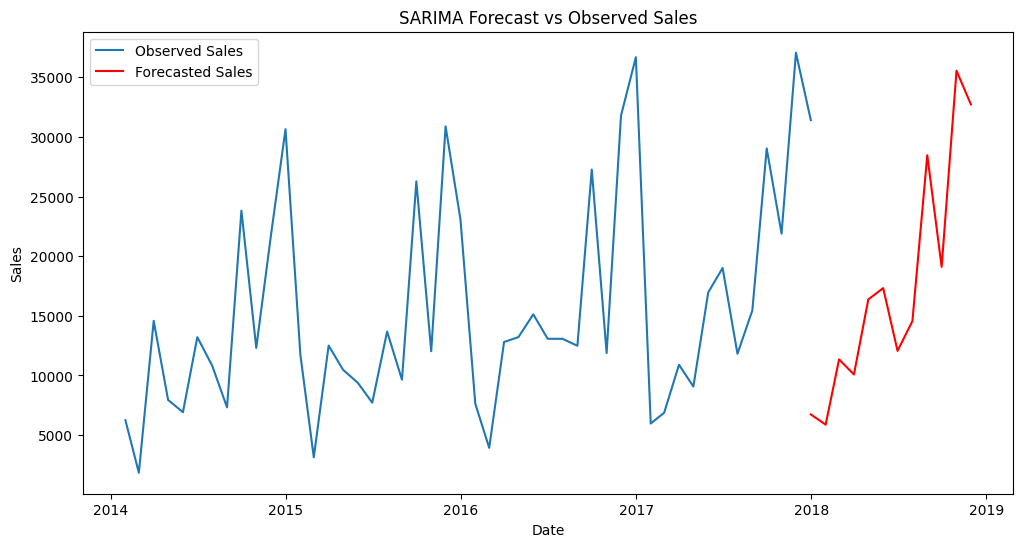

Forecasted Sales:
2018-01-31     6731.928845
2018-02-28     5869.559856
2018-03-31    11342.613088
2018-04-30    10076.689161
2018-05-31    16372.672258
2018-06-30    17320.074557
2018-07-31    12056.371558
2018-08-31    14553.740196
2018-09-30    28460.471738
2018-10-31    19102.671895
2018-11-30    35547.326443
2018-12-31    32728.655855
Freq: ME, Name: predicted_mean, dtype: float64


In [ ]:
# Forecast future sales for the next 12 months
forecast = sarima_results.forecast(steps=12)

# Plot the forecasted values alongside the original time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed Sales')
plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), forecast, label='Forecasted Sales', color='red')
plt.title('SARIMA Forecast vs Observed Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

print("Forecasted Sales:")
print(forecast)


In [ ]:
from sklearn.metrics import mean_squared_error

# Split data into train and test sets (last 12 months as test set)
train = monthly_sales[:-12]
test = monthly_sales[-12:]

# Fit SARIMA model on training set
sarima_model_train = SARIMAX(train, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
sarima_results_train = sarima_model_train.fit()

# Forecast on test set
test_forecast = sarima_results_train.forecast(steps=12)

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test, test_forecast))
mape = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")


RMSE: 3897.6939888594366
MAPE: 44.09%


<ipython-input-7-51e69798906f>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), arima_forecast, label='ARIMA Forecast', color='green')


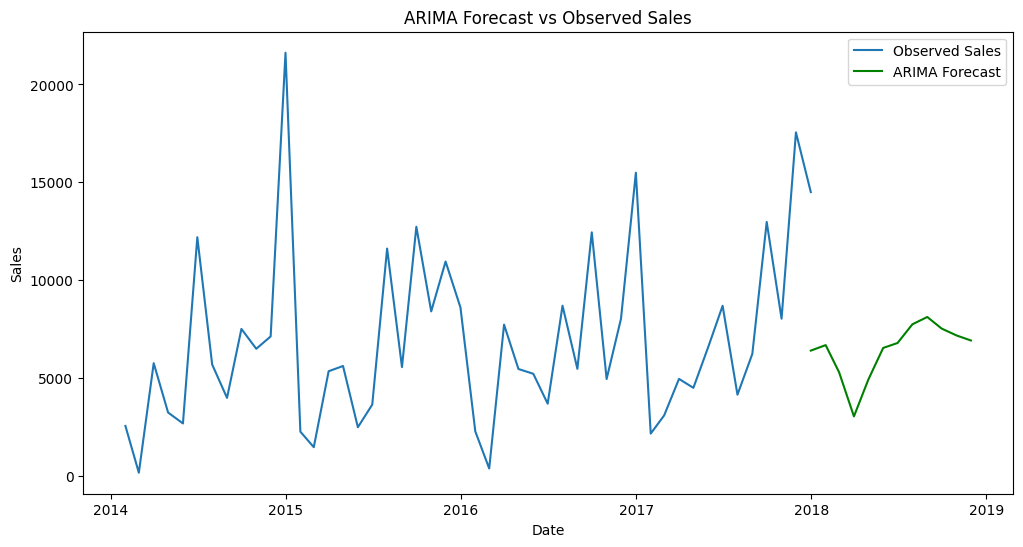

ARIMA RMSE: 4463.504300695093
ARIMA MAPE: nan%


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(monthly_sales, order=(6, 0, 0))
arima_results = arima_model.fit()

# Forecast future sales for the next 12 months
arima_forecast = arima_results.forecast(steps=12)

# Plot the forecasted values alongside the original time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed Sales')
plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), arima_forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast vs Observed Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Evaluate ARIMA model
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print(f"ARIMA RMSE: {arima_rmse}")
print(f"ARIMA MAPE: {arima_mape:.2f}%")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# Calculate MAE
arima_mae = mean_absolute_error(test, arima_forecast)

# Mask to ignore zero actual values in MAPE calculation
nonzero_mask = test != 0
if np.any(nonzero_mask):
    arima_mape = np.mean(np.abs((test[nonzero_mask] - arima_forecast[nonzero_mask]) / test[nonzero_mask])) * 100
else:
    arima_mape = float('nan')  # fallback if all values are zero

print(f"ARIMA RMSE: {arima_rmse}")
print(f"ARIMA MAE: {arima_mae}")
print(f"ARIMA MAPE: {arima_mape:.2f}%")


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0733
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0576
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0448
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0358
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0320
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0342
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0389
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0408
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0393
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0364
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0338
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0324
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0321
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0325
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0333
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/

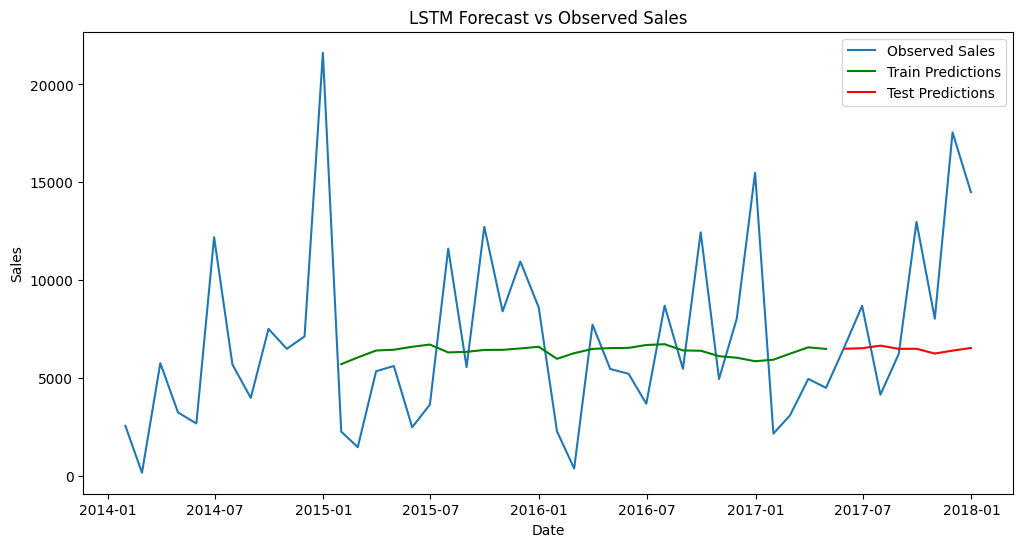

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_sales.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Observed Sales')
plt.plot(monthly_sales.index[time_step:train_size + time_step], train_predict.flatten(), label='Train Predictions', color='green')
plt.plot(monthly_sales.index[train_size + time_step:], test_predict.flatten(), label='Test Predictions', color='red')
plt.title('LSTM Forecast vs Observed Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 288355104.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 257708144.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 275220992.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 272027648.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 277828992.0000 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 288752064.0000
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 290411776.0000
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 243265808.0000
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 268133568.0000
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 236115696.0000
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 271566016.0000 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 289819744.0000
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 254760288.0000
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms

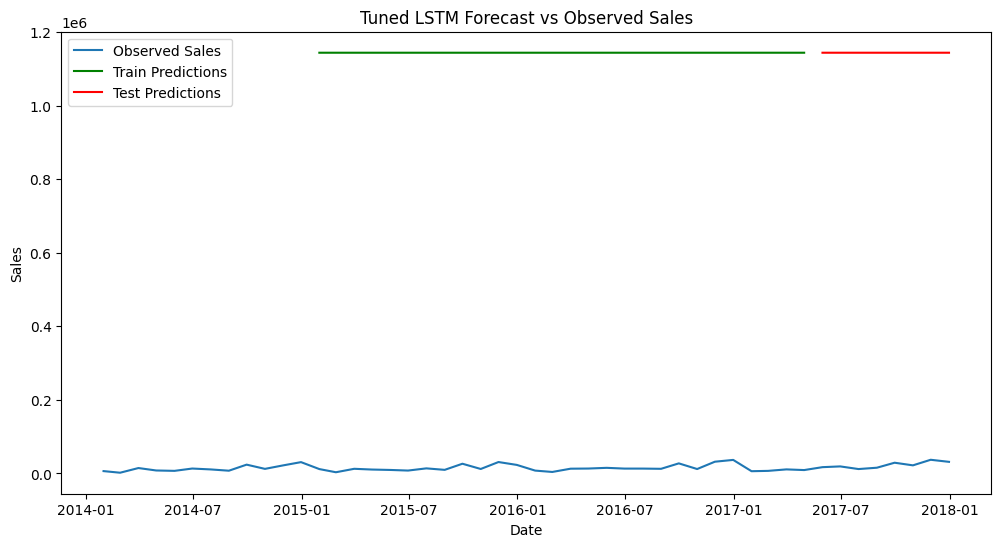

In [ ]:
from tensorflow.keras.optimizers import Adam

# Adjust hyperparameters
time_step = 12
lstm_units = 100  # Increased number of LSTM units
learning_rate = 0.001  # Set a specific learning rate
batch_size = 16  # Reduced batch size
epochs = 100  # Increased number of epochs

# Build the tuned LSTM model
tuned_model = Sequential()
tuned_model.add(LSTM(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
tuned_model.add(LSTM(lstm_units, return_sequences=False))
tuned_model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
tuned_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the tuned model
tuned_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Make predictions
train_predict_tuned = tuned_model.predict(X_train)
test_predict_tuned = tuned_model.predict(X_test)

# Inverse transform predictions
train_predict_tuned = scaler.inverse_transform(train_predict_tuned)
test_predict_tuned = scaler.inverse_transform(test_predict_tuned)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Observed Sales')
plt.plot(monthly_sales.index[time_step:train_size + time_step], train_predict_tuned.flatten(), label='Train Predictions', color='green')
plt.plot(monthly_sales.index[train_size + time_step:], test_predict_tuned.flatten(), label='Test Predictions', color='red')
plt.title('Tuned LSTM Forecast vs Observed Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

# Calculate MAE
lstm_mae = mean_absolute_error(y_test, test_predict)

# Calculate MAPE
lstm_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM MAE: {lstm_mae}")
print(f"LSTM MAPE: {lstm_mape:.2f}%")

LSTM RMSE: 11003.625077229246
LSTM MAE: 8314.695778515626
LSTM MAPE: 30.83%


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1495
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0975
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0610
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0404
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0327
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0344
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0399
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0432
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0427
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0396
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0356
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0321
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0296
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0283
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0279
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/st

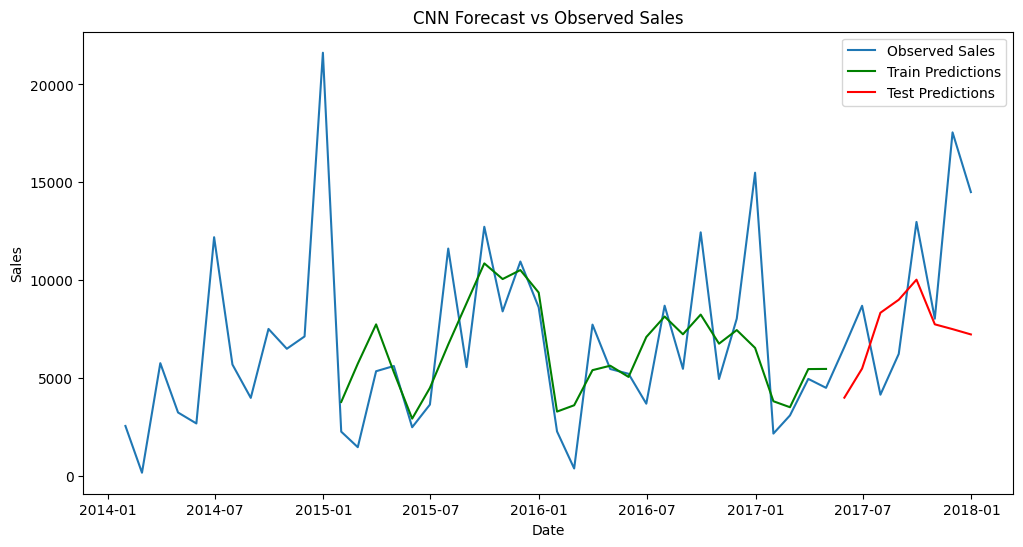

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_sales.values.reshape(-1, 1))

# Prepare the data for CNN
def create_cnn_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_cnn_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
train_predict_cnn = cnn_model.predict(X_train)
test_predict_cnn = cnn_model.predict(X_test)

# Inverse transform predictions
train_predict_cnn = scaler.inverse_transform(train_predict_cnn)
test_predict_cnn = scaler.inverse_transform(test_predict_cnn)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Observed Sales')
plt.plot(monthly_sales.index[time_step:train_size + time_step], train_predict_cnn.flatten(), label='Train Predictions', color='green')
plt.plot(monthly_sales.index[train_size + time_step:], test_predict_cnn.flatten(), label='Test Predictions', color='red')
plt.title('CNN Forecast vs Observed Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE
cnn_rmse = np.sqrt(mean_squared_error(y_test, test_predict_cnn))

# Calculate MAE
cnn_mae = mean_absolute_error(y_test, test_predict_cnn)

# Calculate MAPE
cnn_mape = np.mean(np.abs((y_test - test_predict_cnn) / y_test)) * 100

print(f"CNN RMSE: {cnn_rmse}")
print(f"CNN MAE: {cnn_mae}")
print(f"CNN MAPE: {cnn_mape:.2f}%")

NameError: name 'mean_absolute_error' is not defined

<ipython-input-18-230a16ef22f3>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), forecast, label='SARIMA Forecast', color='red')
<ipython-input-18-230a16ef22f3>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), arima_forecast, label='ARIMA Forecast', color='green')


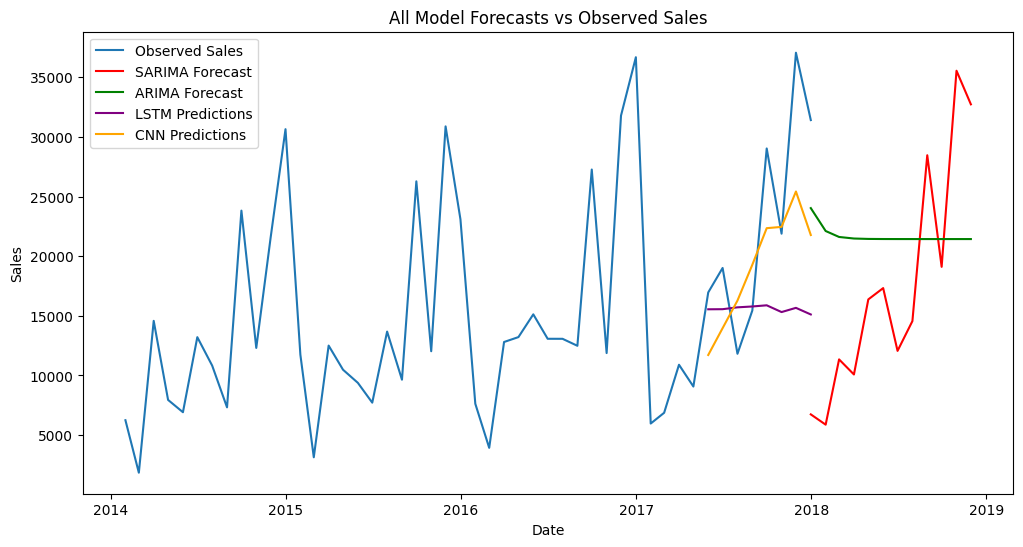

In [ ]:
# prompt: make a graph with all the model predictions

import matplotlib.pyplot as plt

# Assuming 'forecast', 'arima_forecast', 'test_predict', and 'test_predict_cnn' are already defined from previous code

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed Sales')
plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), forecast, label='SARIMA Forecast', color='red')
plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq='M'), arima_forecast, label='ARIMA Forecast', color='green')

# Plot LSTM predictions
plt.plot(monthly_sales.index[train_size + time_step:], test_predict.flatten(), label='LSTM Predictions', color='purple')

# Plot CNN predictions
plt.plot(monthly_sales.index[train_size + time_step:], test_predict_cnn.flatten(), label='CNN Predictions', color='orange')

plt.title('All Model Forecasts vs Observed Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
# prompt: tune the lstm and cnn predictions properly

# ... (Your existing code)

# Tune LSTM hyperparameters
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)
param_grid = {'units': [25, 50, 75,100], 'epochs': [25, 50,75], 'batch_size':[16,32,64]}
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best hyperparameters to train the final LSTM model
best_lstm_model = create_lstm_model(units=grid_result.best_params_['units'])
best_lstm_model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'], verbose=1)

# Make predictions with the tuned model
best_test_predict = best_lstm_model.predict(X_test)
best_test_predict = scaler.inverse_transform(best_test_predict)

# Evaluate tuned LSTM model
best_lstm_rmse = np.sqrt(mean_squared_error(y_test, best_test_predict))
best_lstm_mae = mean_absolute_error(y_test, best_test_predict)
best_lstm_mape = np.mean(np.abs((y_test - best_test_predict) / y_test)) * 100
print(f"Tuned LSTM RMSE: {best_lstm_rmse}")
print(f"Tuned LSTM MAE: {best_lstm_mae}")
print(f"Tuned LSTM MAPE: {best_lstm_mape:.2f}%")

#Plot the tuned results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Observed Sales')
plt.plot(monthly_sales.index[train_size + time_step:], best_test_predict.flatten(), label='Tuned LSTM Test Predictions', color='purple')
plt.title('Tuned LSTM Forecast vs Observed Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


# ... (rest of your code)
